# DNN on MNIST

In this exercice, we are going to do the first Neural Network with Tensorflow. We will explore some models, tweak their topology, activation function and check the impact in Tensorboard. As input we gonna use the mnist dataset included in Tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

% matplotlib inline

In [2]:
#mnist = input_data.read_data_sets("/data/")
mnist = fetch_mldata('MNIST original', data_home="./")

# Presentation of the dataset

Source : <a href="https://en.wikipedia.org/wiki/MNIST_database" target="_blank">Wikipedia</a>

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. [...] The MNIST database contains 60,000 training images and 10,000 testing images. [...] Currently, the best performance of a single convolutional neural network trained in 74 epochs on the expanded training data is 0.27 percent error rate.

In [3]:
X = mnist.data
y = mnist.target.reshape(-1,1)

print(X.shape)
print(y.shape)

(70000, 784)
(70000, 1)


So we have the dataset with 784 inputs corresponding to the 28x28 pixel presenting the picture and an output vector with the label corresponding. To switch to a multiclass classification, we gonna use the OneHotEncoder to "explode" the label to n dictinct columns

In [4]:
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y)

In [5]:
y_dense = y_ohe.toarray().astype(int)
print(y_dense.shape, "\n")
for i in range(10):
    print(y[i*6999], "=>", y_dense[i*6999])

(70000, 10) 

[ 0.] => [1 0 0 0 0 0 0 0 0 0]
[ 1.] => [0 1 0 0 0 0 0 0 0 0]
[ 2.] => [0 0 1 0 0 0 0 0 0 0]
[ 3.] => [0 0 0 1 0 0 0 0 0 0]
[ 4.] => [0 0 0 0 1 0 0 0 0 0]
[ 5.] => [0 0 0 0 0 1 0 0 0 0]
[ 7.] => [0 0 0 0 0 0 0 1 0 0]
[ 8.] => [0 0 0 0 0 0 0 0 1 0]
[ 9.] => [0 0 0 0 0 0 0 0 0 1]
[ 2.] => [0 0 1 0 0 0 0 0 0 0]


Here we are, we now have 10 columns with only with 1 on the label corresponding. We can also plot some input to check how it looks like

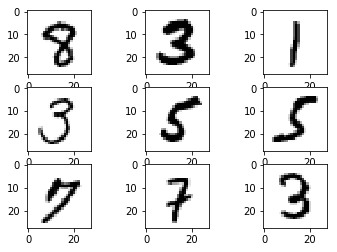

In [6]:
idx = np.random.randint(X.shape[0], size=9)
plt.figure(1)
pos = 331
for choice in X[idx,:]:
    mat = choice.reshape(28,28)
    plt.subplot(pos)
    plt.imshow(mat, cmap='binary')
    pos += 1
plt.show()

We can see that there is an high variety of change which make it very difficult to handle with standard "rules" like :
if pixel[a] > 0 and pixel[b] < 100 ... it's a 3 for example.
But we can try a simple DNN and check if it learn well.

Prior to go for the DNN, we first goona split the dataset in 2 parts : 1 for the training and 1 for the test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dense, test_size=1/7, random_state=42)

In [8]:
print("Training set")
print(X_train.shape)
print(y_train.shape)
print("\n")
print("Test set")
print(X_test.shape)
print(y_test.shape)

Training set
(60000, 784)
(60000, 10)


Test set
(10000, 784)
(10000, 10)


# Creation of the model

As I already experiment some tries on this kind of model, Iwon't explore several Topology/activation functions etc ... The idea is only to show how well it learn from "difficult" inputs. Nevertheless, if you are interested to this, you can take a look to <a href="http://nicolasmine.com/scripts/solution/Neural_Network_Exploration.html" target="_blank">this workbook</a>

In [35]:
def batch_gen(X, y, batch_size = 50, nb_batch = None):
    if nb_batch is None:
        nb_batch = X.shape[0] // batch_size
    randomize = np.arange(X.shape[0])
    np.random.shuffle(randomize)
    X = X[randomize]
    y = y[randomize]
    for _ in range(nb_batch):
        X_chunk = X[:batch_size]
        y_chunk = y[:batch_size]
        yield (X_chunk, y_chunk)
        X, y = X[batch_size:], y[batch_size:]

In [36]:
input_features = 28*28
size_hidden_layer_1 = 300
size_hidden_layer_2 = 50
size_output_layer = 10
dropout_rate = 0.5

In [37]:
tf.reset_default_graph()
tf.set_random_seed(42)

In [38]:
# Creation Graph
X_ph = tf.placeholder(tf.float32, shape=(None, input_features), name='X')
y_ph = tf.placeholder(tf.int32, shape=(None, size_output_layer), name='y')
training_ph = tf.placeholder_with_default(False, shape=(), name='training')

In [39]:
# Setup Dropout
X_drop = tf.layers.dropout(X_ph, dropout_rate, training = training_ph)

# Hidden Layer
hidden_layer_1 = tf.layers.dense(X_drop, size_hidden_layer_1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden_layer_1, training=training_ph, momentum=0.9)
bn1_act = tf.nn.elu(bn1)
hidden_layer_1_drop = tf.layers.dropout(bn1_act, dropout_rate, training = training_ph)

hidden_layer_2 = tf.layers.dense(hidden_layer_1_drop, size_hidden_layer_2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden_layer_2, training=training_ph, momentum=0.9)
bn2_act = tf.nn.elu(bn2)   
hidden_layer_2_drop = tf.layers.dropout(bn2_act, dropout_rate, training = training_ph)

output_layer = tf.layers.dense(hidden_layer_2_drop, size_output_layer, name="output")

In [40]:
predict = tf.contrib.layers.softmax(output_layer) #tf.nn.softmax(output_layer)

In [41]:
# Cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_ph, logits=output_layer)
loss= tf.reduce_mean(cross_entropy)

In [42]:
# Backpropagation
LR = 0.01
optimizer = tf.train.MomentumOptimizer(LR, momentum=0.9).minimize(loss)

In [43]:
# evaluation
# correct = tf.nn.in_top_k(output_layer, y_ph, 1)
correct = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y_ph, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [44]:
# Initialization
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Tensorborad info
acc_summary = tf.summary.scalar("Accuracy", accuracy)
file_writter = tf.summary.FileWriter("/saves/summary/model1/", tf.get_default_graph())

In [45]:
training = True
n_epoch = 60

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epoch):
        batch = batch_gen(X_train, y_train, 50)
        for X_batch, y_batch in batch:
            sess.run(optimizer, feed_dict={X_ph: X_batch, y_ph: y_batch, training_ph: True})
        #accuracy_str = acc_summary.eval(feed_dict={X: X_test, y: mnist.test.labels})
        #file_writter.add_summary(accuracy_str, epoch)
        print(epoch, accuracy.eval(feed_dict={X_ph: X_test, y_ph: y_test}))
    save_path = saver.save(sess, "/saves/trained_model.ckpt")
    #file_writter.close()

0 0.8359
1 0.8649
2 0.8589
3 0.8475
4 0.8952
5 0.9151
6 0.8874
7 0.9078
8 0.9032
9 0.8857
10 0.8911
11 0.8846
12 0.9013
13 0.8997
14 0.9004
15 0.8921
16 0.8872
17 0.892
18 0.8977
19 0.8952
20 0.8995
21 0.9147
22 0.9101
23 0.8982
24 0.9026
25 0.9081
26 0.8968
27 0.9034
28 0.9062
29 0.9058
30 0.9103
31 0.9108
32 0.926
33 0.9271
34 0.917
35 0.9195
36 0.9258
37 0.9419
38 0.9265
39 0.9332
40 0.9248
41 0.9317
42 0.9317
43 0.9311
44 0.9354
45 0.9329
46 0.9344
47 0.9341
48 0.9373
49 0.9257
50 0.9268
51 0.9268
52 0.9245
53 0.9297
54 0.9329
55 0.9263
56 0.9329
57 0.9357
58 0.9349
59 0.9346


INFO:tensorflow:Restoring parameters from /saves/trained_model.ckpt


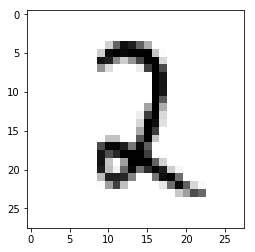

Real Value : 2
OHE Real : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [-5699  4334  9229  3012 -4057 -5011 -6493  4688 -3209  -923]
inf


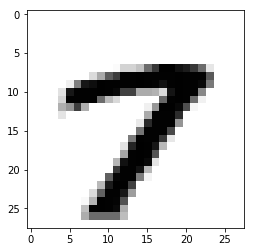

Real Value : 7
OHE Real : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [-14213   3820   7365   5391  -7390  -6804 -14216  19862  -2264   3299]
inf


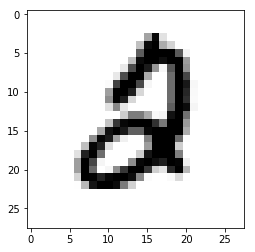

Real Value : 2
OHE Real : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [ -400 -1708  5340  1516 -2500 -3484 -3747 -1207 -1607  1262]
inf


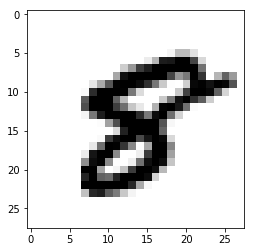

Real Value : 8
OHE Real : [0 0 0 0 0 0 0 0 1 0]
OHE Pred : [0 0 0 0 0 0 0 0 1 0]
OHE Pred : [-4441 -2200 -1949  3759 -4720  3512 -5535   327  7506  3856]
inf


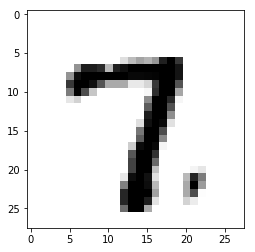

Real Value : 7
OHE Real : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [-13044   6279   9527   6663  -5432  -7234 -12525  14474  -3288  -1256]
inf


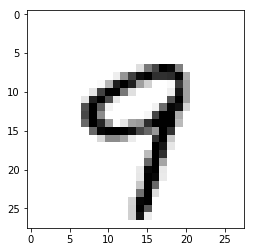

Real Value : 9
OHE Real : [0 0 0 0 0 0 0 0 0 1]
OHE Pred : [0 0 0 0 0 0 0 0 0 1]
OHE Pred : [-8558 -2798 -5456  1571  1730 -2632 -8602  7480 -6285 11935]
inf


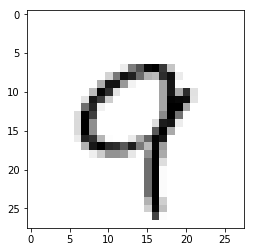

Real Value : 9
OHE Real : [0 0 0 0 0 0 0 0 0 1]
OHE Pred : [0 0 0 0 0 0 0 0 0 1]
OHE Pred : [-8047 -2512 -2872   326  1201 -4788 -7754  7771 -7281 11247]
inf


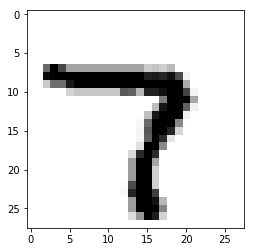

Real Value : 7
OHE Real : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [0 0 0 0 0 0 0 1 0 0]
OHE Pred : [-14428   4115   3346   2242  -3099 -11266 -12684  24200  -9472   4765]
inf


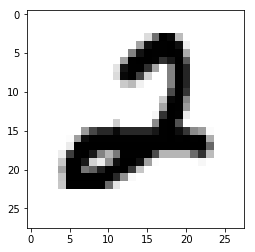

Real Value : 2
OHE Real : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [0 0 1 0 0 0 0 0 0 0]
OHE Pred : [ -6859   1845  14497   4161  -3647 -11692 -10004   9518  -7879  -1300]
inf


In [46]:
with tf.Session() as sess:
    saver.restore(sess, "/saves/trained_model.ckpt")
    idx = np.random.randint(X_test.shape[0], size=9)
    x_eval = X_test[idx]
    y_eval = y_test[idx]
    y_pred, out = sess.run([predict, output_layer], feed_dict={X_ph: x_eval})
    for i in range(9):
        mat = x_eval[i].reshape(28,28)
        plt.imshow(mat, cmap='binary')
        plt.show()
        print("Real Value :", np.argmax(y_eval[i]))
        print("OHE Real :", y_eval[i])
        print("OHE Pred :", y_pred[i].astype(int))
        print("OHE Pred :", out[i].astype(int))
        numerateur = tf.exp(out[i])
        sum_prob = tf.reduce_sum(tf.exp(out[i]))
        pro = tf.divide(numerateur, sum_prob)
        print(sum_prob.eval())